In [201]:
import fiona
import numpy as np
import pandas as pd
from panel import Panel
from rendering import *

%load_ext autoreload
%autoreload 2

set_up()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [202]:
filename = 'qgis_assets/modulos_automatico_final_new_fixed_geometry.shp'
shp = fiona.open(filename)

In [203]:
def load_panels(shp):
    panels = []
    cluster = dict()

    for (idx, elem) in enumerate(shp):
        panel = Panel()
        panel.id_array = elem['properties']['ID_ARRAY']
        panel.id_panel = elem['properties']['ID_CELL']
        panel.row = elem['properties']['ID_ROW']
        panel.col = elem['properties']['ID_COL']
        panel.geometry = elem['geometry']['coordinates'][0]
        panel.compute_centroid()

        panels.append(panel)
        if panel.id_array not in cluster:
            cluster[panel.id_array] = []
        cluster[panel.id_array].append(idx)

    plot_panels(panels, color_code=[panel.id_array for panel in panels], draw_text=True, text=[str(panel.id_array) for panel in panels], draw_legend=True, savefig='results/panels.png')

    return panels, cluster

In [204]:
def stress_missing_panels(panels, cluster, nrows=1, missing_panels_p=0.05):
    # Miss entire rows
    for key in cluster:
        row_panels = dict()
        rows = {}
        for idx in cluster[key]:
            if panels[idx].row not in row_panels:
                row_panels[panels[idx].row] = []
            row_panels[panels[idx].row].append(idx)
            rows[panels[idx].row] = 1

        rows = list(rows.keys())
        rows.sort()

        # Pick one random row
        for _ in range(nrows):
            if len(rows) > 2:
                random_row = np.random.choice(rows[1:-2])

                for idx in row_panels[random_row]:
                    panels[idx] = None
                    cluster[key].remove(idx)
                rows.remove(random_row)
                row_panels.pop(random_row)

    # Miss random panels
    for key in cluster:
        num_panels = len(cluster[key])
        num_missing_panels = int(num_panels * missing_panels_p)
        missing_panels = np.random.choice(cluster[key], num_missing_panels, replace=False)

        for idx in missing_panels:
            cluster[key].remove(idx)
            panels[idx] = None

    # Gather non-null panels
    plot_panels([panel for panel in panels if panel is not None], color_code=[panel.id_array for panel in panels if panel is not None], draw_legend=True, savefig='results/reduced_panels.png')

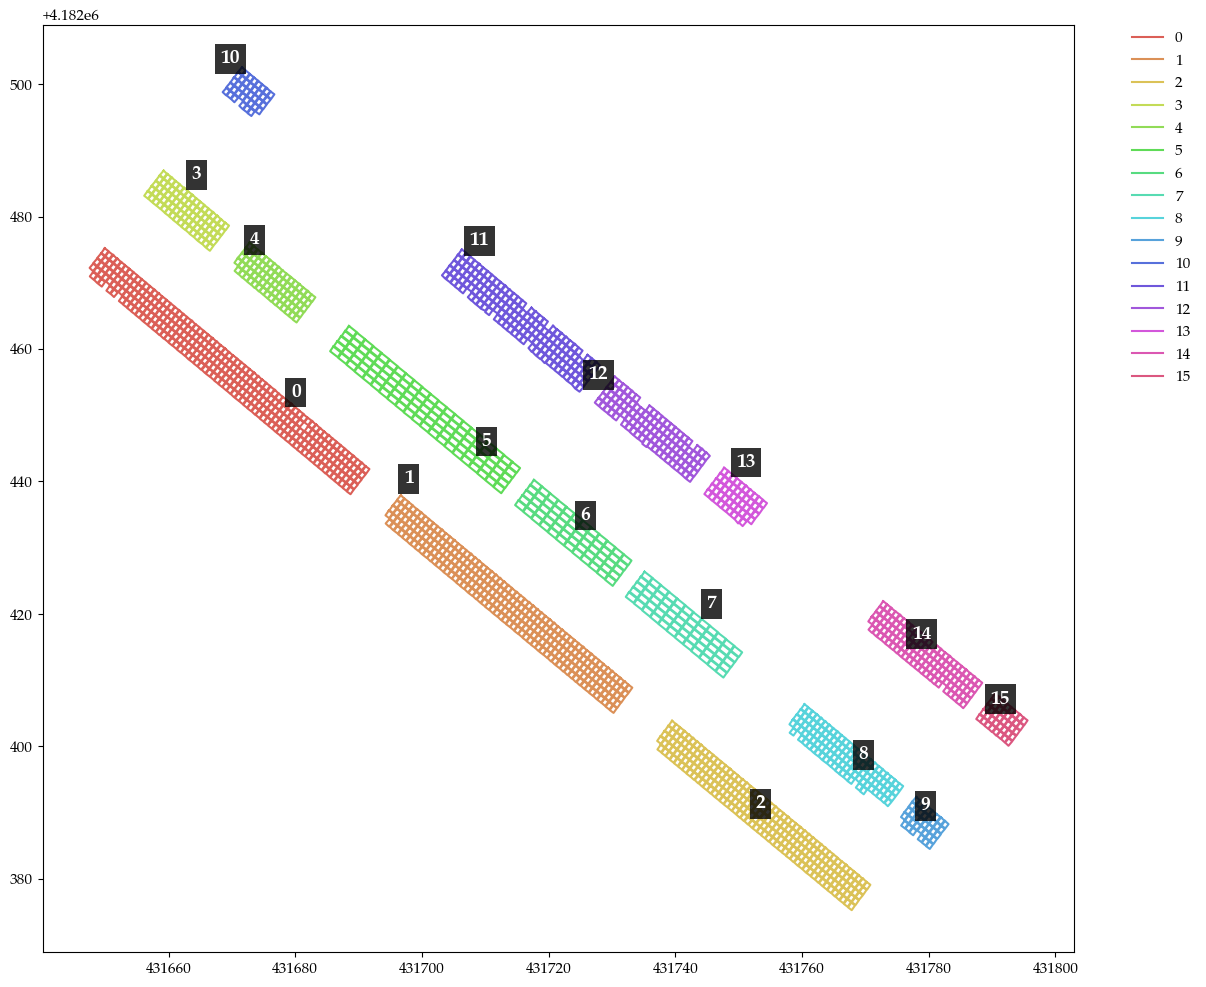

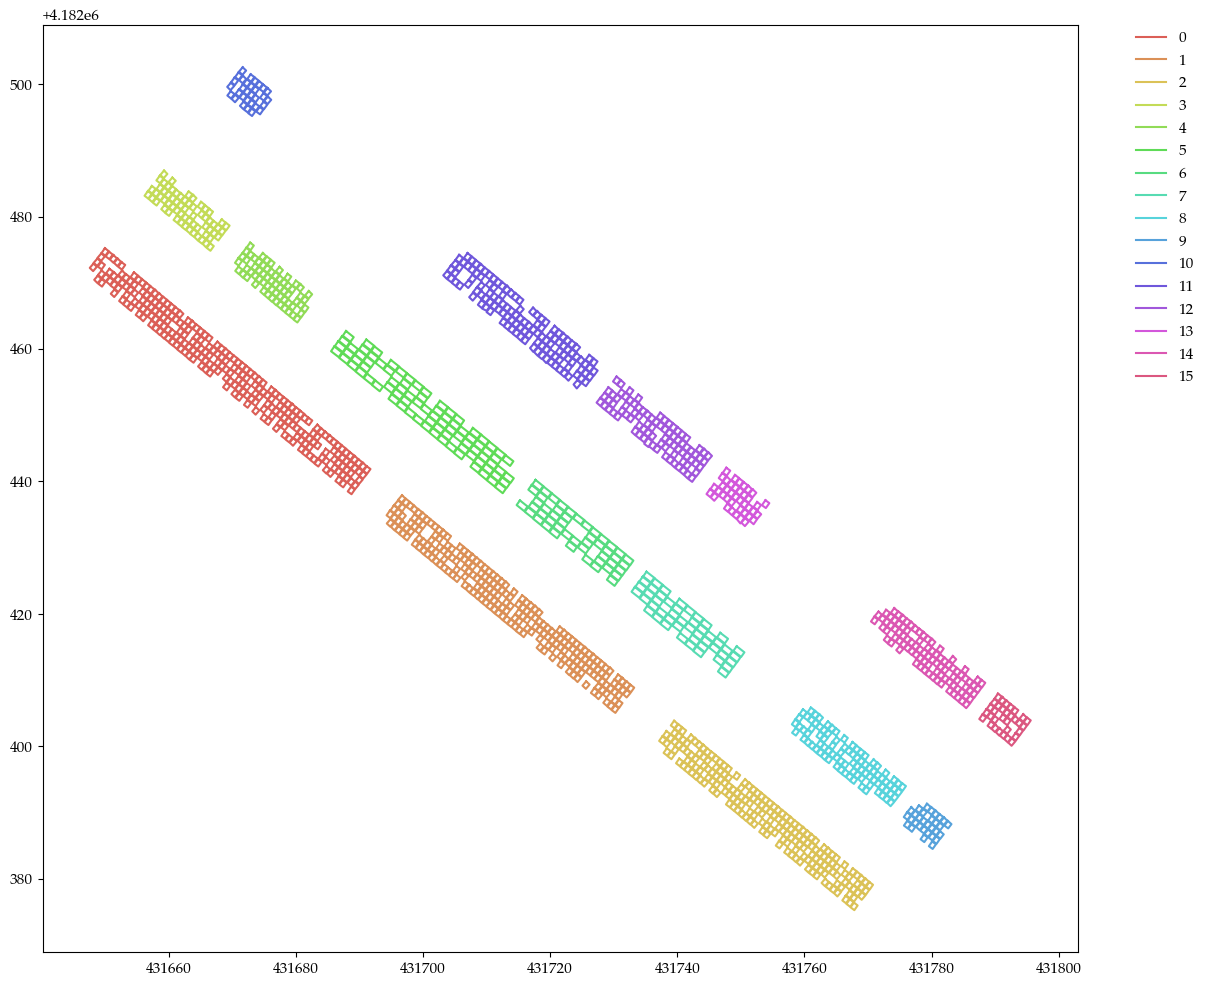

In [205]:
panels, cluster = load_panels(shp)
stress_missing_panels(panels, cluster, nrows=0, missing_panels_p=0.2)

In [206]:
# Write back
schema = shp.schema.copy()
input_crs = shp.crs

with fiona.open(filename.split('.')[0] + '_foo.shp', 'w', 'ESRI Shapefile', schema, input_crs) as output:
    # for elem in shp:
    #     output.write({'properties': elem['properties'], 'geometry': elem['geometry']})

    for panel in panels:
        if panel is None:
            continue

        # Build geometry buffer
        geometry_buffer = [[]]
        for point in panel.geometry:
            geometry_buffer[0].append((point[0], point[1]))

        output.write({'properties': {'No.': -1, 'Area (Ha)': -1, 'Perimetro(': panel.get_perimeter(), 'Area(m2)': panel.get_area(), 'Perimetr_1': panel.get_perimeter(), 'ID_ARRAY': -1, 'ID_CELL': -1, 'ID_ROW': -1, 'ID_COL': -1}, 'geometry': {'type': 'Polygon', 'coordinates': geometry_buffer }})